In [1]:
import tensorflow as tf
import numpy as np
import tf_integrator as tf_int
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
%matplotlib inline

In [2]:
with open('model.pkl', 'rb') as fp:
    model = pickle.load(fp)

sim_time = 800#model['duration'] # simulation time (in ms)
sim_res = model['resolution'] # simulation resolution (in ms)

t = np.arange(0.0, sim_time, sim_res) # time array

In [3]:
# Defining Neuron Counts

n_n = model['n_n']           # number of neurons
p_n = int(0.75*n_n)                  # number of PNs
l_n = int(0.25*n_n)                  # number of LNs

C_m  = [1.43]*n_n                     # Capacitance

# Defining Common Current Parameters #

g_K  = [1.0]*n_n                    # K conductance
g_L  = [0.0215]*n_n                    # Leak conductance
g_KL  = [0.0057]*p_n + [0.0029]*l_n      # K leak conductance (first 90 for PNs and next 30 for LNs)

E_K  = [-95.0]*n_n                   # K Potential
E_L  = [-55.0]*p_n + [-50.0]*l_n     # Leak Potential (first 90 for PNs and next 30 for LNs)
E_KL  = [-95.0]*n_n                  # K Leak Potential
# Defining Cell Type Specific Current Parameters #

## PNs

g_Na = [7.15]*p_n                   # Na conductance
g_A  = [1.43]*p_n                    # Transient K conductance

E_Na = [50.0]*p_n                    # Na Potential
E_A  = [-95.0]*p_n                   # Transient K Potential

## LNs

g_Ca = [0.29]*l_n                     # Ca conductance
g_KCa = [0.0359]*l_n                    # Ca dependent K conductance

E_Ca = [140.0]*l_n                   # Ca Potential
E_KCa = [-95]*l_n                    # Ca dependent K Potential

A_Ca = 2.86*(10**(-5))                  # Ca outflow rate
Ca0 = 2.4*(10**(-4))                 # Equilibrium Calcium Concentration
t_Ca = 150                           # Ca recovery time constant

## Defining Firing Thresholds ##

F_b = [0.0]*n_n                      # Fire threshold

## Defining Acetylcholine Synapse Connectivity ##

#ach_mat = model["achmat"] #np.zeros((n_n,n_n))
ach_mat = np.zeros(model["achmat"].shape)

## Defining Acetylcholine Synapse Parameters ##

n_syn_ach = int(np.sum(ach_mat))     # Number of Acetylcholine (Ach) Synapses 
alp_ach = [10.0]*n_syn_ach           # Alpha for Ach Synapse
bet_ach = [0.2]*n_syn_ach            # Beta for Ach Synapse
t_max = 0.3                          # Maximum Time for Synapse
t_delay = 0                          # Axonal Transmission Delay
A = [0.5]*n_n                        # Synaptic Response Strength
# g_ach = [0.009]*p_n+[0.045]*l_n         # Ach Conductance
g_ach = [0.35]*p_n+[0.3]*l_n         # Ach Conductance
E_ach = [0.0]*n_n                    # Ach Potential

## Defining GABAa Synapse Connectivity ##

fgaba_mat = model["gabamat"] #np.zeros((n_n,n_n)) 
# fgaba_mat = np.zeros(model["gabamat"].shape) 

## Defining GABAa Synapse Parameters ##
    
n_syn_fgaba = int(np.sum(fgaba_mat)) # Number of GABAa (fGABA) Synapses
alp_fgaba = [10.0]*n_syn_fgaba       # Alpha for fGABA Synapse
bet_fgaba = [0.16]*n_syn_fgaba       # Beta for fGABA Synapse
V0 = [-20.0]*n_n                     # Decay Potential
sigma = [1.5]*n_n                    # Decay Time Constant
#g_fgaba = [0.36]*p_n+[0.3]*l_n        # fGABA Conductance
g_fgaba = [0.8]*p_n+[0.4]*l_n        # fGABA Conductance
E_fgaba = [-70.0]*n_n                # fGABA Potential

## Defining GABAslow Synapse Connectivity ##

sgaba_mat = model["gabamat"] #np.zeros((n_n,n_n))
# sgaba_mat = np.zeros(model["gabamat"].shape)

## Defining GABAslow Synapse Parameters ##
    
n_syn_sgaba = int(np.sum(sgaba_mat)) # Number of GABAslow (sGABA) Synapses
K_sgaba = [100e-12]*n_syn_sgaba          # K for sGABA Synapse
r1_sgaba = [0.5]*n_syn_sgaba         # r1 for sGABA Synapse
r2_sgaba = [0.0013]*n_syn_sgaba      # r2 for sGABA Synapse
r3_sgaba = [0.1]*n_syn_sgaba         # r3 for sGABA Synapse
r4_sgaba = [0.033]*n_syn_sgaba       # r4 for sGABA Synapse
V0_sgaba = [-20.0]*n_n               # Decay Potential
sigma_sgaba = [1.5]*n_n              # Decay Time Constant
# G_sgaba = [0.36]*p_n+[0.0]*l_n      # sGABA Conductance
G_sgaba = [0.8]*p_n+[0.0]*l_n      # sGABA Conductance
E_sgaba = [-95.0]*n_n                # sGABA Potential

g_ach = np.divide(np.array(g_ach),np.sum(ach_mat,axis=1),where=np.sum(ach_mat,axis=1)!=0)
G_sgaba = np.divide(np.array(G_sgaba),np.sum(sgaba_mat,axis=1),where=np.sum(sgaba_mat,axis=1)!=0)
g_fgaba = np.divide(np.array(g_fgaba),np.sum(fgaba_mat,axis=1),where=np.sum(fgaba_mat,axis=1)!=0)

In [4]:
def K_prop(V):
    
    V = V-(-65)
    
    T = 23
    
    phi = 3.0**((T-36)/10)
    
    alpha_n = 0.032*(15-V)/(tf.exp((15-V)*0.2) - 1.0)
    beta_n = 0.5*tf.exp((10.0-V)/40.0)
    
    t_n = 1.0/(alpha_n+beta_n)/phi
    n_inf = alpha_n/(alpha_n+beta_n)
    
    return n_inf, t_n


def Na_prop(V):
    
    V = V-(-65)
    
    T = 23
    
    phi = 3.0**((T-36)/10)
    
    alpha_m = 0.32*(13-V)/(tf.exp((13-V)*0.25)-1)
    beta_m = 0.28*(V-40)/(tf.exp((V-40)*0.2)-1)
    
    alpha_h = 0.128*tf.exp((17-V)/18.0)
    beta_h = 4.0/(tf.exp((40-V)*0.2) + 1.0)
    
    t_m = 1.0/(alpha_m+beta_m)/phi
    t_h = 1.0/(alpha_h+beta_h)/phi
    
    m_inf = alpha_m/(alpha_m+beta_m)
    h_inf = alpha_h/(alpha_h+beta_h)
    
    return m_inf, t_m, h_inf, t_h


def A_prop(V):
    
    T = 23
    
    phi = 3.0**((T-23.5)/10)
    
    m_inf = 1/(1+tf.exp(-(V+60.0)/8.5))
    h_inf = 1/(1+tf.exp((V+78.0)/6.0))
    
    tau_m = 0.27/(tf.exp((V + 35.8)/19.7) + tf.exp(-(V + 79.7)/12.7)) + 0.1
    
    t1 = 0.27*1/(tf.exp((V+46.05)/5.0) + tf.exp(-(V+238.4)/37.45)) #/ phi
    t2 = tf.ones(tf.shape(V),dtype=V.dtype)*(19.0/phi) #*5.1 
    tau_h = tf.where(tf.less(V,-63.0),t1,t2)
    
    return m_inf, tau_m, h_inf, tau_h


def Ca_prop(V):
    
    m_inf = 1/(1+tf.exp(-(V+20.0)/6.5))
    h_inf = 1/(1+tf.exp((V+25.0)/12))
    
    tau_m = 1.5#1 + (V + 30)*0.014#1.5
    tau_h = 0.3*tf.exp((V-40.0)/13.0) + 0.002*tf.exp((60.0-V)/29)
    
    return m_inf, tau_m, h_inf, tau_h

def KCa_prop(Ca):
    return Ca/(Ca+2), 100/(Ca+2)

In [5]:
# NEURONAL CURRENTS

# Common Currents #

def I_K(V, n):
    return g_K  * n**4 * (V - E_K)

def I_L(V):
    return g_L * (V - E_L)

def I_KL(V):
    return g_KL * (V - E_KL)

# PN Currents #

def I_Na(V, m, h):
    return g_Na * m**3 * h * (V - E_Na)

def I_A(V, m, h):
    return g_A * m**4 * h * (V - E_A)

# LN Currents #

def I_Ca(V, m, h):
    return g_Ca * m**2 * h * (V - E_Ca)

def I_KCa(V, m):
    T = 23
    phi = 2.3**((T-23.0)/10)
    return g_KCa * m * (V - E_KCa) * phi

# SYNAPTIC CURRENTS

def I_ach(o,V):
    o_ = tf.Variable([0.0]*n_n**2,dtype=tf.float64)
    ind = tf.boolean_mask(tf.range(n_n**2),ach_mat.reshape(-1) == 1)
    o_ = tf.scatter_update(o_,ind,o)
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n)))
    return tf.reduce_sum(tf.transpose((o_*(V-E_ach))*g_ach),1)

def I_fgaba(o,V):
    o_ = tf.Variable([0.0]*n_n**2,dtype=tf.float64)
    ind = tf.boolean_mask(tf.range(n_n**2),fgaba_mat.reshape(-1) == 1)
    o_ = tf.scatter_update(o_,ind,o)
    o_ = tf.transpose(tf.reshape(o_,(n_n,n_n)))
    return tf.reduce_sum(tf.transpose((o_*(V-E_fgaba))*g_fgaba),1)

def I_sgaba(G,V):
    G4 = tf.pow(G,4)/(tf.pow(G,4)+K_sgaba)
    G_ = tf.Variable([0.0]*n_n**2,dtype=tf.float64)
    ind = tf.boolean_mask(tf.range(n_n**2),sgaba_mat.reshape(-1) == 1)
    G_ = tf.scatter_update(G_,ind,G4)
    G_ = tf.transpose(tf.reshape(G_,(n_n,n_n)))
    return tf.reduce_sum(tf.transpose((G_*(V-E_sgaba))*G_sgaba),1)

# INPUT CURRENTS

def I_inj_t(t):
    return tf.constant(current_input.T,dtype=tf.float64)[tf.to_int32(t*100)]

In [6]:
def dXdt(X, t): # X is the state vector
    
    V_p   = X[0   : p_n] # Voltage(PN)
    V_l   = X[p_n : n_n] # Voltage(LN)
    
    n_K   = X[n_n : 2*n_n] # K-gating(ALL)
    
    m_Na  = X[2*n_n : 2*n_n + p_n] # Na-activation-gating(PN)
    h_Na  = X[2*n_n + p_n : 2*n_n + 2*p_n] # Na-inactivation-gating(PN)

    m_A   = X[2*n_n + 2*p_n : 2*n_n + 3*p_n] # Transient-K-activation-gating(PN)
    h_A   = X[2*n_n + 3*p_n : 2*n_n + 4*p_n] # Transient-K-inactivation-gating(PN)
    
    m_Ca  = X[2*n_n + 4*p_n : 2*n_n + 4*p_n + l_n] # Ca-activation-gating(LN)
    h_Ca  = X[2*n_n + 4*p_n + l_n: 2*n_n + 4*p_n + 2*l_n] # Ca-inactivation-gating(LN)
    
    m_KCa = X[2*n_n + 4*p_n + 2*l_n : 2*n_n + 4*p_n + 3*l_n] # K(Ca)-gating(LN)
    Ca    = X[2*n_n + 4*p_n + 3*l_n: 2*n_n + 4*p_n + 4*l_n] # Ca-concentration(LN)

    o_ach = X[6*n_n : 6*n_n + n_syn_ach] # Acetylcholine Open Fraction
    o_fgaba = X[6*n_n + n_syn_ach : 6*n_n + n_syn_ach + n_syn_fgaba] # GABAa Open Fraction
    r_sgaba = X[6*n_n + n_syn_ach + n_syn_fgaba : 6*n_n + n_syn_ach + n_syn_fgaba + n_syn_sgaba] # GABAa Open Fraction
    g_sgaba = X[6*n_n + n_syn_ach + n_syn_fgaba + n_syn_sgaba : 6*n_n + n_syn_ach + n_syn_fgaba + 2*n_syn_sgaba] # GABAa Open Fraction    
    fire_t = X[-n_n:] # Fire-times
    
    V = X[:n_n] # Overall Voltage (PN + LN)
    
    
    # Evaluate Differentials for Gating variables and Ca concentration
    
    n0,tn = K_prop(V)
    
    dn_k = - (1.0/tn)*(n_K-n0)
    
    m0,tm,h0,th = Na_prop(V_p)
    
    dm_Na = - (1.0/tm)*(m_Na-m0)
    dh_Na = - (1.0/th)*(h_Na-h0)
    
    m0,tm,h0,th = A_prop(V_p)
    
    dm_A = - (1.0/tm)*(m_A-m0)
    dh_A = - (1.0/th)*(h_A-h0)
    
    m0,tm,h0,th = Ca_prop(V_l)
    
    dm_Ca = - (1.0/tm)*(m_Ca-m0)
    dh_Ca = - (1.0/th)*(h_Ca-h0)
    
    m0,tm = KCa_prop(Ca)
    
    dm_KCa = - (1.0/tm)*(m_KCa-m0)
    
    dCa = - A_Ca*I_Ca(V_l,m_Ca,h_Ca) - (Ca - Ca0)/t_Ca
    
    # Evaluate differential for Voltage
    
    CmdV_p = - I_Na(V_p, m_Na, h_Na) - I_A(V_p, m_A, h_A)
    CmdV_l = - I_Ca(V_l, m_Ca, h_Ca) - I_KCa(V_l, m_KCa)
    
    # Once we have that, we merge the two into a single 120-vector.
    
    CmdV = tf.concat([CmdV_p,CmdV_l],0)
    
    # Finally we add the common currents and divide by Cm to get dV/dt.
    
    dV = (I_inj_t(t) + CmdV - I_K(V, n_K) - I_L(V) - I_KL(V) - I_ach(o_ach,V) - I_fgaba(o_fgaba,V) - I_sgaba(g_sgaba,V)) / C_m
#     dV = (I_inj_t(t) + CmdV - I_K(V, n_K) - I_L(V) - I_KL(V) - I_ach(o_ach,V) - I_fgaba(o_fgaba,V)) / C_m
    
    # Evaluate dynamics in synapses
    
    A_ = tf.constant(A,dtype=tf.float64)
    T_ach = tf.where(tf.logical_and(tf.greater(t,fire_t+t_delay),tf.less(t,fire_t+t_max+t_delay)),A_,tf.zeros(tf.shape(A_),dtype=A_.dtype))
    T_ach = tf.multiply(tf.constant(ach_mat,dtype=tf.float64),T_ach)
    T_ach = tf.boolean_mask(tf.reshape(T_ach,(-1,)),ach_mat.reshape(-1) == 1)
    do_achdt = alp_ach*(1.0-o_ach)*T_ach - bet_ach*o_ach
    
    T_fgaba = 1.0/(1.0+tf.exp(-(V-V0)/sigma))
    T_fgaba = tf.multiply(tf.constant(fgaba_mat,dtype=tf.float64),T_fgaba)
    T_fgaba = tf.boolean_mask(tf.reshape(T_fgaba,(-1,)),fgaba_mat.reshape(-1) == 1)
    do_fgabadt = alp_fgaba*(1.0-o_fgaba)*T_fgaba - bet_fgaba*o_fgaba
    
    dg_sgabadt = - np.array(r4_sgaba)*g_sgaba + np.array(r3_sgaba)*r_sgaba 
    
    A_ = tf.constant(A,dtype=tf.float64)
    T_sgaba = tf.where(tf.logical_and(tf.greater(t,fire_t+t_delay),tf.less(t,fire_t+t_max+t_delay)),A_,tf.zeros(tf.shape(A_),dtype=A_.dtype))
    T_sgaba = tf.multiply(tf.constant(sgaba_mat,dtype=tf.float64),T_sgaba)
    T_sgaba = tf.boolean_mask(tf.reshape(T_sgaba,(-1,)),sgaba_mat.reshape(-1) == 1)
    dr_sgabadt = r1_sgaba*(1.0-r_sgaba)*T_sgaba - r2_sgaba*r_sgaba
    
    # Set change in fire-times as zero
    
    dfdt = tf.zeros(tf.shape(fire_t),dtype=fire_t.dtype)

    # Combine to a single vector
    
    out = tf.concat([dV,         dn_k,
                     dm_Na,      dh_Na,
                     dm_A,       dh_A,
                     dm_Ca,      dh_Ca,
                     dm_KCa,     
                     dCa,        do_achdt,
                     do_fgabadt, dr_sgabadt,
                     dg_sgabadt, dfdt   ],0)
    return out

In [7]:
current_input = 0.*np.ones((n_n,t.shape[0]))

# Create the input shape

y = np.where(t<550,(1-np.exp(-(t-50)/75)),np.exp(-(t-550)/300))
y = np.where(t<50,0.0*np.ones(t.shape),y)

# Randomly choose 33% indices from 120

p_input = 0.33
p_input_l = 1.0
input_neurons_pn = np.random.choice(np.array(range(p_n)),int(p_input*p_n),replace=False)
input_neurons_ln = 90+np.random.choice(np.array(range(l_n)),int(p_input_l*l_n),replace=False)

# Assign input shape to chosen indices
for i in input_neurons_pn:
    current_input[i,:]= (np.random.normal(loc=8,scale=0.0)+0.1*np.random.normal(size=t.shape))*y
    
for i in input_neurons_ln:
    current_input[i,:]= (np.random.normal(loc=5,scale=0.0)+0.1*np.random.normal(size=t.shape))*y

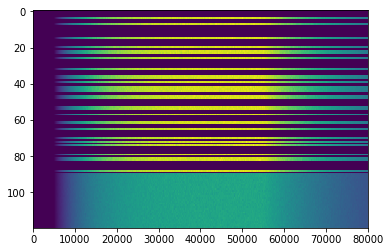

In [8]:
# plt.plot(current_input.T[::100,:])
# plt.show()
plt.imshow(current_input,aspect='auto')

In [9]:
state_vector =  [-60]* n_n + [0.0]* (n_n + 4*p_n + 3*l_n) + [2.4*(10**(-4))]*l_n + [0]*(n_syn_ach+n_syn_fgaba+2*n_syn_sgaba) + [-(sim_time+1)]*n_n
state_vector = np.array(state_vector)
state_vector = state_vector + 0.3*state_vector*np.random.normal(size=state_vector.shape)
init_state = tf.constant(state_vector, dtype=tf.float64)

In [10]:
%%time
ts = time.time()

state = tf_int.odeint(dXdt, init_state, t, n_n, F_b)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    state = sess.run(state)
    sess.close()

ResourceExhaustedError: OOM when allocating tensor with shape[79999,6072] and type double on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node scan/TensorArrayStack/TensorArrayGatherV3 (defined at /home/iiser/Collins-Saptarshi 2019b/DAMN/Drawing Board/AL Model/Locust Bazhenov (no GABAb)/tf_integrator.py:59)  = TensorArrayGatherV3[dtype=DT_DOUBLE, element_shape=[6072], _device="/job:localhost/replica:0/task:0/device:CPU:0"](scan/TensorArray_2, scan/TensorArrayStack/range, scan/while/Exit_3)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'scan/TensorArrayStack/TensorArrayGatherV3', defined at:
  File "/home/iiser/.conda/envs/venv/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/iiser/.conda/envs/venv/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/iiser/.conda/envs/venv/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/home/iiser/.conda/envs/venv/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-2728217053cb>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', 'ts = time.time()\n\nstate = tf_int.odeint(dXdt, init_state, t, n_n, F_b)\n\nwith tf.Session() as sess:\n    tf.global_variables_initializer().run()\n    state = sess.run(state)\n    sess.close()\n')
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2323, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-62>", line 2, in time
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/IPython/core/magics/execution.py", line 1271, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 3, in <module>
  File "/home/iiser/Collins-Saptarshi 2019b/DAMN/Drawing Board/AL Model/Locust Bazhenov (no GABAb)/tf_integrator.py", line 78, in odeint
    return _Tf_Integrator(n_, F_b).integrate(func,y0,t)
  File "/home/iiser/Collins-Saptarshi 2019b/DAMN/Drawing Board/AL Model/Locust Bazhenov (no GABAb)/tf_integrator.py", line 59, in integrate
    y = tf.scan(scan_func, (t[:-1], time_delta_grid),y0)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tensorflow/python/ops/functional_ops.py", line 720, in scan
    results_flat = [r.stack() for r in r_a]
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tensorflow/python/ops/functional_ops.py", line 720, in <listcomp>
    results_flat = [r.stack() for r in r_a]
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tensorflow/python/ops/tensor_array_ops.py", line 856, in stack
    return self._implementation.stack(name=name)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tensorflow/python/ops/tensor_array_ops.py", line 289, in stack
    return self.gather(math_ops.range(0, self.size()), name=name)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tensorflow/python/ops/tensor_array_ops.py", line 303, in gather
    element_shape=element_shape)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 6031, in tensor_array_gather_v3
    flow_in=flow_in, dtype=dtype, element_shape=element_shape, name=name)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/iiser/.conda/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[79999,6072] and type double on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node scan/TensorArrayStack/TensorArrayGatherV3 (defined at /home/iiser/Collins-Saptarshi 2019b/DAMN/Drawing Board/AL Model/Locust Bazhenov (no GABAb)/tf_integrator.py:59)  = TensorArrayGatherV3[dtype=DT_DOUBLE, element_shape=[6072], _device="/job:localhost/replica:0/task:0/device:CPU:0"](scan/TensorArray_2, scan/TensorArrayStack/range, scan/while/Exit_3)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [11]:
plt.figure(figsize=(12,6))
    
sns.heatmap(state[::100,:90].T,xticklabels=100,yticklabels=5,cmap='Greys')

plt.xlabel("Time (in ms)")
plt.ylabel("Projection Neuron Number")
plt.title("Voltage vs Time Heatmap for Projection Neurons (PNs)")

plt.tight_layout()
plt.show()


AttributeError: 'Tensor' object has no attribute 'T'

<Figure size 864x432 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,6))
    
sns.heatmap(state[::100,90:120].T,xticklabels=100,yticklabels=5,cmap='Greys')

plt.xlabel("Time (in ms)")
plt.ylabel("Local Interneuron Number")
plt.title("Voltage vs Time Heatmap for Local Interneurons (LNs)")

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
for i in range(30):
    plt.plot(100*i+state[::100,i])

In [ ]:
plt.plot(state[::100,:90].mean(axis=1))

In [ ]:
y = state[5000:55000,:90].mean(axis=1)

Y = np.fft.fft(y)
freq = np.fft.fftfreq(len(y), 0.01/1000)

ind = np.logical_and(freq>0,freq<200)

plt.plot( freq[ind], np.abs(Y)[ind] )

In [ ]:
state[:,:90]

In [ ]:
with tf.Session() as sess:
    stateK = sess.run(K_prop(np.linspace(-150,150,300)))
    stateNa = sess.run(Na_prop(np.linspace(-150,150,300)))
    plt.plot(np.linspace(-150,150,300),stateK[0],'r')
    plt.plot(np.linspace(-150,150,300),stateNa[0],'b')    
    plt.plot(np.linspace(-150,150,300),stateNa[2],'g')
    plt.show()
    plt.plot(np.linspace(-150,150,300),stateK[1],'r')
    plt.plot(np.linspace(-150,150,300),stateNa[1]*10,'b')    
    plt.plot(np.linspace(-150,150,300),stateNa[3],'g')

In [ ]:
plt.imshow(ach_mat)

In [ ]:
np.array(G_sgaba)/np.sum(sgaba_mat,axis=1)

In [ ]:
plt.hist(g_ach)

In [ ]:
g_ach